In [23]:
# from google.colab import drive
# drive.mount('/content/gdrive')

In [24]:
from sklearn import cluster,datasets,mixture
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np
import os 


import torch
from torch import nn
from torch import distributions
from itertools import chain
from torch import optim

In [25]:
cuda=torch.device('cuda:0')

In [26]:
n_samples = 3000
moons = datasets.make_moons(n_samples=n_samples,noise=0.05)

In [27]:
Xtrain,Ytrain=moons
scale=StandardScaler()
Xtrain=scale.fit_transform(Xtrain)

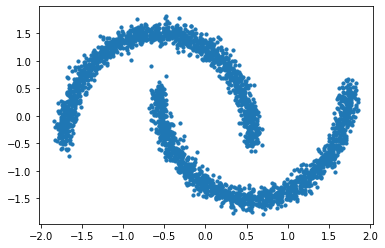

In [28]:
plt.scatter(Xtrain[:,0],Xtrain[:,1],s=10)

In [29]:
masks=torch.tensor(np.array([[0, 1], [1, 0]] * 3).astype(np.float32)).to(cuda)

In [30]:
class network_scale(nn.Module):
  def __init__(self,ip_shape):
    super(network_scale,self).__init__()

    self.layer1=nn.Sequential(nn.Linear(ip_shape,256),nn.LeakyReLU())
    self.layer2=nn.Sequential(nn.Linear(256,256),nn.LeakyReLU())
    self.layer4=nn.Sequential(nn.Linear(256,ip_shape),nn.Tanh())
  
  def forward(self,x):

    x=self.layer1(x)
    x=self.layer2(x)
    #x=self.layer3(x)
    x=self.layer4(x)

    return x
  
class network_transl(nn.Module):
  def __init__(self,ip_shape):
    super(network_transl,self).__init__()

    self.layer1=nn.Sequential(nn.Linear(ip_shape,256),nn.LeakyReLU())
    self.layer2=nn.Sequential(nn.Linear(256,256),nn.LeakyReLU())
    self.layer4=nn.Sequential(nn.Linear(256,ip_shape))
  
  def forward(self,x):

    x=self.layer1(x)
    x=self.layer2(x)
    #x=self.layer3(x)
    x=self.layer4(x)

    return x
  
  

In [31]:
input_dim=2
net_scale=nn.ModuleList([network_scale(input_dim).to(cuda) for i in masks])
net_translate=nn.ModuleList([network_transl(input_dim).to(cuda) for i in masks])

In [32]:
#converting z to x
def fwd_nvp_block(z,scale_ntw,translate_ntw,curr_mask):
  new_x=curr_mask*z

  s=scale_ntw(new_x)*(1-curr_mask)
  t=translate_ntw(new_x)*(1-curr_mask)

  new_sec_dim=(1-curr_mask)*(torch.exp(s)*z+t)

  return new_x+new_sec_dim

In [33]:
#converting x to z
def inv_nvp_block(x,scale_ntw,translate_ntw,curr_mask):
  new_z=curr_mask*x

  s=scale_ntw(new_z)*(1-curr_mask)
  t=translate_ntw(new_z)*(1-curr_mask)

  new_sec_dim=(1-curr_mask)*((x-t)*torch.exp(-s))

  lod_J_det=s.sum(dim=1)

  return new_z+new_sec_dim,lod_J_det

In [34]:
def stacked_nvp_fwd(z,masks,scaler_ntws,translator_nwts):
  x=z
  for i in range(len(masks)):
    x=fwd_nvp_block(x,scaler_ntws[i],translator_nwts[i],masks[i])
  return x

In [35]:
def stacked_nvp_inv(x,masks,scaler_ntws,translator_nwts):
  z=x
  Jacobian_det=x.new_zeros(x.shape[0])
  for i in reversed(range(len(masks))):
    z,temp=inv_nvp_block(z,scaler_ntws[i],translator_nwts[i],masks[i])
    Jacobian_det-=temp
  return z,Jacobian_det

In [36]:
def sample_from_z(z):
  x=stacked_nvp_fwd(z,masks,net_scale,net_translate)
  return x

In [37]:
#### z
latent_space_dist = distributions.MultivariateNormal(torch.zeros(2), torch.eye(2))

In [38]:
params = list(net_scale.parameters()) + list(net_translate.parameters())
opt = optim.Adam(params, lr=1e-4)

In [39]:
epochs=3000
batch_s=512
for i in range(epochs):
  freshly_sampled_x,_=datasets.make_moons(n_samples=batch_s,noise=0.05)

  opt.zero_grad()

  transformed_z,jacobian_det=stacked_nvp_inv(torch.tensor(freshly_sampled_x).to(cuda).float(),masks,net_scale,net_translate)

  ####calculating the NLL of the input distribution using the transformed z obtained using transforming z using the transformation of variable formula

  loss = torch.log(torch.tensor([2*np.pi])).to(cuda) + torch.mean(torch.sum(0.5*transformed_z**2, -1) - jacobian_det)

  loss.backward()

  opt.step()

  if i%500 == 0:
    print('epoch %s:' % i, 'loss: %.3f' % loss)

epoch 0: loss: 2.761
epoch 500: loss: 0.548
epoch 1000: loss: 0.471
epoch 1500: loss: 0.407
epoch 2000: loss: 0.403
epoch 2500: loss: 0.334


In [40]:
X, label = datasets.make_moons(n_samples = 1000, noise = 0.05)
X = torch.Tensor(X).to(cuda)
z, logdet_jacobian = stacked_nvp_inv(X,masks,net_scale,net_translate)
z = z.cpu().detach().numpy()

Text(0, 0.5, '$z_2$')

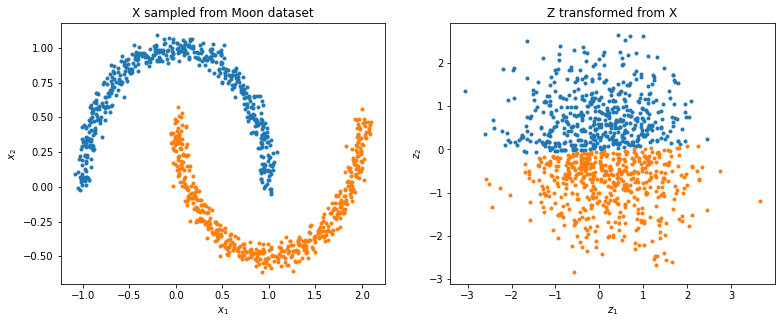

In [41]:
X = X.cpu().detach().numpy()
fig = plt.figure(2, figsize = (12.8, 4.8))
fig.clf()
plt.subplot(1,2,1)
plt.plot(X[label==0,0], X[label==0,1], ".")
plt.plot(X[label==1,0], X[label==1,1], ".")
plt.title("X sampled from Moon dataset")
plt.xlabel(r"$x_1$")
plt.ylabel(r"$x_2$")

plt.subplot(1,2,2)
plt.plot(z[label==0,0], z[label==0,1], ".")
plt.plot(z[label==1,0], z[label==1,1], ".")
plt.title("Z transformed from X")
plt.xlabel(r"$z_1$")
plt.ylabel(r"$z_2$")
# plt.savefig("./output/moon_z_transformed_from_x.png")

Text(0, 0.5, '$x_2$')

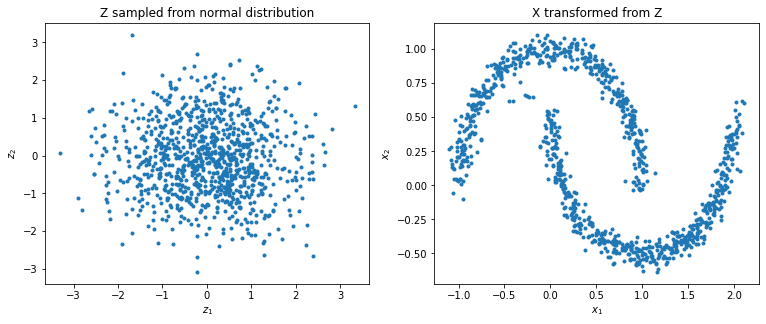

In [42]:
z = torch.normal(0, 1, size = (1000, 2)).to(cuda)
X= stacked_nvp_fwd(z,masks,net_scale,net_translate)
X = X.cpu().detach().numpy()
z = z.cpu().detach().numpy()

fig = plt.figure(2, figsize = (12.8, 4.8))
fig.clf()
plt.subplot(1,2,1)
plt.plot(z[:,0], z[:,1], ".")
plt.title("Z sampled from normal distribution")
plt.xlabel(r"$z_1$")
plt.ylabel(r"$z_2$")

plt.subplot(1,2,2)
plt.plot(X[:,0], X[:,1], ".")
plt.title("X transformed from Z")
plt.xlabel(r"$x_1$")
plt.ylabel(r"$x_2$")
#plt.savefig("./output/moon_x_transformed_from_z.png")